## **Project: A Trilogy of GANs on MNIST**

This notebook implements and compares three foundational types of Generative Adversarial Networks.

*   **Part 1: Vanilla GAN**: The original GAN architecture using Binary Cross-Entropy loss.
*   **Part 2: Wasserstein GAN (WGAN)**: An improved architecture using Wasserstein loss and weight clipping to enhance training stability.
*   **Part 3: Spectral Normalization GAN (SNGAN)**: A modern approach using Spectral Normalization and Hinge Loss for even more stable and high-quality training.

### **Common Setup: Imports and Reproducibility**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from torchvision.utils import save_image
import numpy as np
import random

In [2]:
# --- Set a Global Random Seed for Reproducibility ---
# This ensures that weight initializations, data shuffling, and noise vectors are the same for each run,
# allowing for a fair comparison between the models.
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # For multi-GPU setups
    # The following two lines are for full reproducibility on GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 100
image_size = 28 * 28
batch_size = 128
num_epochs = 50

# Image processing and dataset loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.24MB/s]


---

## **Part 1: Vanilla GAN with BCE Loss**

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid() # Outputs a probability
        )

    def forward(self, x):
        return self.model(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, image_size),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [5]:
learning_rate_vanilla = 0.0002

discriminator_vanilla = Discriminator().to(device)
generator_vanilla = Generator().to(device)
criterion = nn.BCELoss()
d_optimizer_vanilla = optim.Adam(discriminator_vanilla.parameters(), lr=learning_rate_vanilla)
g_optimizer_vanilla = optim.Adam(generator_vanilla.parameters(), lr=learning_rate_vanilla)
d_losses_vanilla, g_losses_vanilla = [], []

os.makedirs('vanilla_gan_samples', exist_ok=True)

print("Starting Vanilla GAN Training...")
for epoch in range(num_epochs):
    epoch_d_loss, epoch_g_loss = 0.0, 0.0
    for i, (images, _) in enumerate(train_loader):
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)
        images = images.reshape(-1, image_size).to(device)

        d_optimizer_vanilla.zero_grad()
        d_real_outputs = discriminator_vanilla(images)
        d_loss_real = criterion(d_real_outputs, real_labels)
        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images = generator_vanilla(z)
        d_fake_outputs = discriminator_vanilla(fake_images.detach())
        d_loss_fake = criterion(d_fake_outputs, fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer_vanilla.step()

        g_optimizer_vanilla.zero_grad()
        g_outputs = discriminator_vanilla(fake_images)
        g_loss = criterion(g_outputs, real_labels)
        g_loss.backward()
        g_optimizer_vanilla.step()

        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()

    avg_d_loss = epoch_d_loss / len(train_loader)
    avg_g_loss = epoch_g_loss / len(train_loader)
    d_losses_vanilla.append(avg_d_loss)
    g_losses_vanilla.append(avg_g_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}')

print("Vanilla GAN Training finished.")

Starting Vanilla GAN Training...
Epoch [1/50], D Loss: 0.5724, G Loss: 3.5371
Epoch [2/50], D Loss: 0.5303, G Loss: 3.3323
Epoch [3/50], D Loss: 0.8558, G Loss: 2.3385
Epoch [4/50], D Loss: 0.8458, G Loss: 2.7774
Epoch [5/50], D Loss: 1.1185, G Loss: 2.0056
Epoch [6/50], D Loss: 1.1933, G Loss: 2.0702
Epoch [7/50], D Loss: 1.2112, G Loss: 2.1464
Epoch [8/50], D Loss: 1.0813, G Loss: 1.6654
Epoch [9/50], D Loss: 0.9060, G Loss: 1.7896
Epoch [10/50], D Loss: 0.6319, G Loss: 2.3653
Epoch [11/50], D Loss: 0.6195, G Loss: 2.3977
Epoch [12/50], D Loss: 0.6485, G Loss: 2.5455
Epoch [13/50], D Loss: 0.5769, G Loss: 3.0423
Epoch [14/50], D Loss: 0.5216, G Loss: 3.0470
Epoch [15/50], D Loss: 0.5751, G Loss: 2.8559
Epoch [16/50], D Loss: 0.5288, G Loss: 2.8231
Epoch [17/50], D Loss: 0.6179, G Loss: 2.5799
Epoch [18/50], D Loss: 0.6575, G Loss: 2.7438
Epoch [19/50], D Loss: 0.5196, G Loss: 3.0139
Epoch [20/50], D Loss: 0.5461, G Loss: 3.1352
Epoch [21/50], D Loss: 0.5466, G Loss: 3.0050
Epoch [22/

---

## **Part 2: Wasserstein GAN (WGAN) with Weight Clipping**

In [6]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1) # No Sigmoid for WGAN critic
        )

    def forward(self, x):
        return self.model(x)

In [7]:
learning_rate_wgan = 0.00005
critic_iterations = 5
clip_value = 0.01

critic_wgan = Critic().to(device)
generator_wgan = Generator().to(device)
d_optimizer_wgan = optim.RMSprop(critic_wgan.parameters(), lr=learning_rate_wgan)
g_optimizer_wgan = optim.RMSprop(generator_wgan.parameters(), lr=learning_rate_wgan)
d_losses_wgan, g_losses_wgan = [], []

os.makedirs('wgan_samples', exist_ok=True)

print("Starting WGAN Training...")
for epoch in range(num_epochs):
    epoch_d_loss, epoch_g_loss = 0.0, 0.0
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(-1, image_size).to(device)

        for _ in range(critic_iterations):
            d_optimizer_wgan.zero_grad()
            z = torch.randn(images.size(0), latent_dim).to(device)
            fake_images = generator_wgan(z).detach()
            real_output = critic_wgan(images)
            fake_output = critic_wgan(fake_images)
            d_loss = -(torch.mean(real_output) - torch.mean(fake_output))
            d_loss.backward()
            d_optimizer_wgan.step()
            for p in critic_wgan.parameters():
                p.data.clamp_(-clip_value, clip_value)

        epoch_d_loss += d_loss.item()

        g_optimizer_wgan.zero_grad()
        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images_for_g = generator_wgan(z)
        g_loss = -torch.mean(critic_wgan(fake_images_for_g))
        g_loss.backward()
        g_optimizer_wgan.step()

        epoch_g_loss += g_loss.item()

    avg_d_loss = epoch_d_loss / len(train_loader)
    avg_g_loss = epoch_g_loss / len(train_loader)
    d_losses_wgan.append(avg_d_loss)
    g_losses_wgan.append(avg_g_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Critic Loss: {avg_d_loss:.4f}, Generator Loss: {avg_g_loss:.4f}')

print("WGAN Training finished.")

Starting WGAN Training...
Epoch [1/50], Critic Loss: -0.3194, Generator Loss: -8.4952
Epoch [2/50], Critic Loss: -0.3690, Generator Loss: -2.2280
Epoch [3/50], Critic Loss: -0.4624, Generator Loss: -3.2388
Epoch [4/50], Critic Loss: -0.3976, Generator Loss: -1.8376
Epoch [5/50], Critic Loss: -0.3802, Generator Loss: -1.0402
Epoch [6/50], Critic Loss: -0.3132, Generator Loss: -0.9213
Epoch [7/50], Critic Loss: -0.3363, Generator Loss: -0.6788
Epoch [8/50], Critic Loss: -0.3184, Generator Loss: -0.3997
Epoch [9/50], Critic Loss: -0.3037, Generator Loss: -0.5513
Epoch [10/50], Critic Loss: -0.2577, Generator Loss: -0.5241
Epoch [11/50], Critic Loss: -0.2649, Generator Loss: -0.4034
Epoch [12/50], Critic Loss: -0.2800, Generator Loss: -0.3008
Epoch [13/50], Critic Loss: -0.3071, Generator Loss: -0.1000
Epoch [14/50], Critic Loss: -0.2989, Generator Loss: -0.0841
Epoch [15/50], Critic Loss: -0.2900, Generator Loss: -0.0440
Epoch [16/50], Critic Loss: -0.3009, Generator Loss: -0.0420
Epoch [

---

## **Part 3: Spectral Normalization GAN (SNGAN) with Hinge Loss**

In [8]:
from torch.nn.utils import spectral_norm

class SNGAN_Discriminator(nn.Module):
    def __init__(self):
        super(SNGAN_Discriminator, self).__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Linear(image_size, 512)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(256, 1))
        )

    def forward(self, x):
        return self.model(x)

In [9]:
learning_rate_sngan = 0.0002

discriminator_sngan = SNGAN_Discriminator().to(device)
generator_sngan = Generator().to(device)
d_optimizer_sngan = optim.Adam(discriminator_sngan.parameters(), lr=learning_rate_sngan, betas=(0.5, 0.999))
g_optimizer_sngan = optim.Adam(generator_sngan.parameters(), lr=learning_rate_sngan, betas=(0.5, 0.999))
d_losses_sngan, g_losses_sngan = [], []

os.makedirs('sngan_samples', exist_ok=True)

print("Starting SNGAN Training...")
for epoch in range(num_epochs):
    epoch_d_loss, epoch_g_loss = 0.0, 0.0
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(-1, image_size).to(device)

        d_optimizer_sngan.zero_grad()
        real_output = discriminator_sngan(images)
        d_loss_real = torch.mean(nn.ReLU()(1.0 - real_output))
        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images = generator_sngan(z).detach()
        fake_output = discriminator_sngan(fake_images)
        d_loss_fake = torch.mean(nn.ReLU()(1.0 + fake_output))
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer_sngan.step()
        epoch_d_loss += d_loss.item()

        g_optimizer_sngan.zero_grad()
        z = torch.randn(images.size(0), latent_dim).to(device)
        fake_images_for_g = generator_sngan(z)
        g_output = discriminator_sngan(fake_images_for_g)
        g_loss = -torch.mean(g_output)
        g_loss.backward()
        g_optimizer_sngan.step()
        epoch_g_loss += g_loss.item()

    avg_d_loss = epoch_d_loss / len(train_loader)
    avg_g_loss = epoch_g_loss / len(train_loader)
    d_losses_sngan.append(avg_d_loss)
    g_losses_sngan.append(avg_g_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Discriminator Loss: {avg_d_loss:.4f}, Generator Loss: {avg_g_loss:.4f}')

print("SNGAN Training finished.")

Starting SNGAN Training...
Epoch [1/50], Discriminator Loss: 1.0612, Generator Loss: 0.5171
Epoch [2/50], Discriminator Loss: 0.8019, Generator Loss: 0.8446
Epoch [3/50], Discriminator Loss: 0.6554, Generator Loss: 0.9217
Epoch [4/50], Discriminator Loss: 0.5468, Generator Loss: 0.9963
Epoch [5/50], Discriminator Loss: 0.5689, Generator Loss: 0.9738
Epoch [6/50], Discriminator Loss: 0.6512, Generator Loss: 0.9031
Epoch [7/50], Discriminator Loss: 0.6861, Generator Loss: 0.8901
Epoch [8/50], Discriminator Loss: 0.6301, Generator Loss: 0.9442
Epoch [9/50], Discriminator Loss: 0.6278, Generator Loss: 0.9317
Epoch [10/50], Discriminator Loss: 0.6850, Generator Loss: 0.9279
Epoch [11/50], Discriminator Loss: 0.6961, Generator Loss: 0.8986
Epoch [12/50], Discriminator Loss: 0.8657, Generator Loss: 0.7914
Epoch [13/50], Discriminator Loss: 0.9739, Generator Loss: 0.7308
Epoch [14/50], Discriminator Loss: 1.0253, Generator Loss: 0.7156
Epoch [15/50], Discriminator Loss: 1.0273, Generator Loss:

---

## **Part 4: Evaluation and Comparison**

#### **Loss Curve Plots**

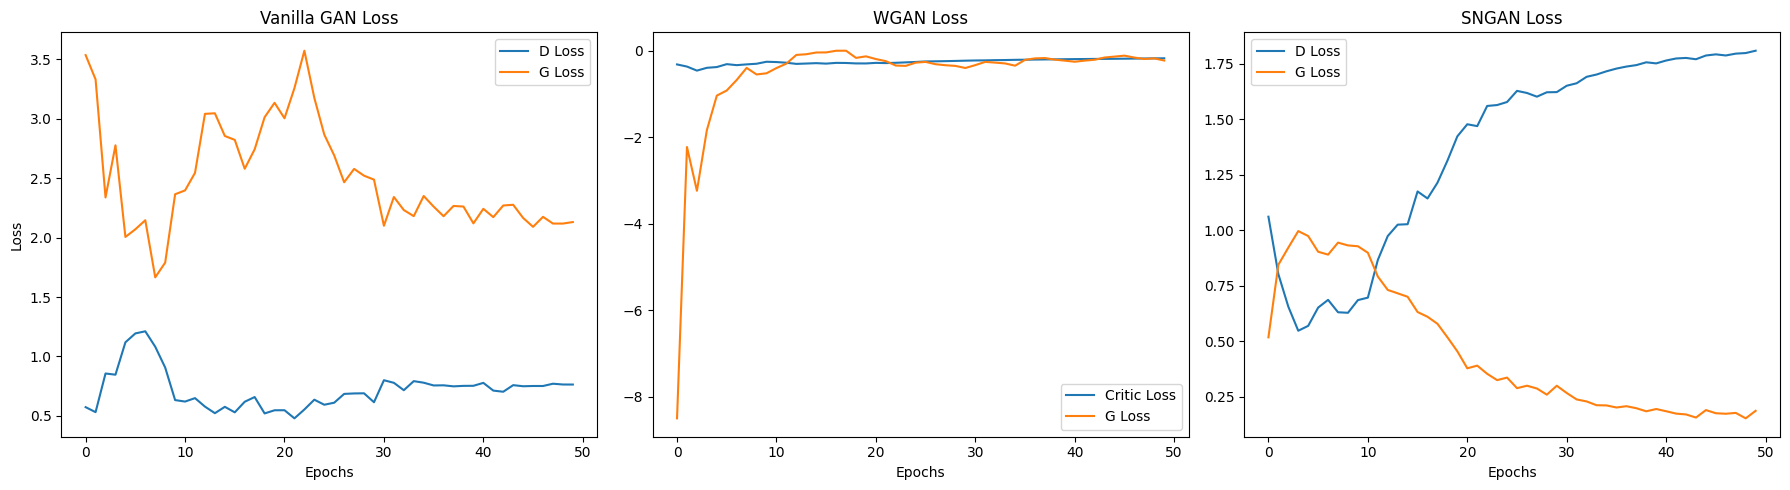

In [10]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.title("Vanilla GAN Loss")
plt.plot(d_losses_vanilla, label="D Loss")
plt.plot(g_losses_vanilla, label="G Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.title("WGAN Loss")
plt.plot(d_losses_wgan, label="Critic Loss")
plt.plot(g_losses_wgan, label="G Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 3, 3)
plt.title("SNGAN Loss")
plt.plot(d_losses_sngan, label="D Loss")
plt.plot(g_losses_sngan, label="G Loss")
plt.xlabel("Epochs")
plt.legend()

plt.tight_layout()
plt.savefig('all_loss_curves.png')
plt.show()

#### **Final Generated Samples (Fair Comparison)**

Displaying final samples. Each model received the exact same input noise.


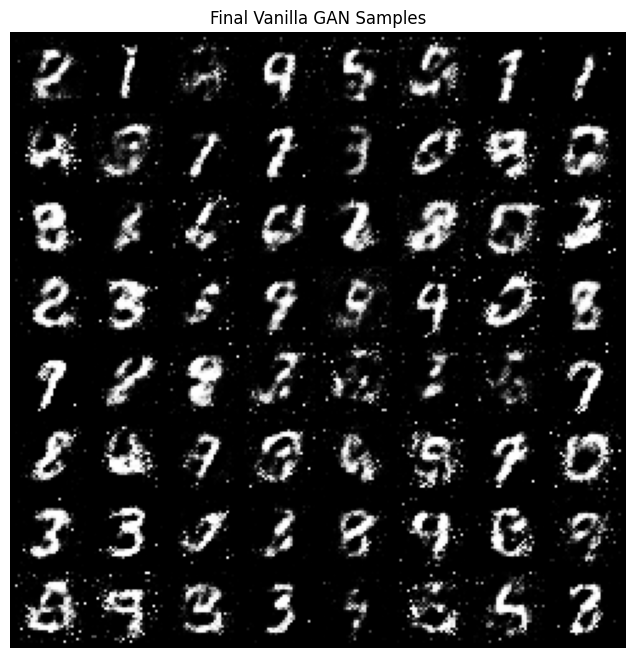

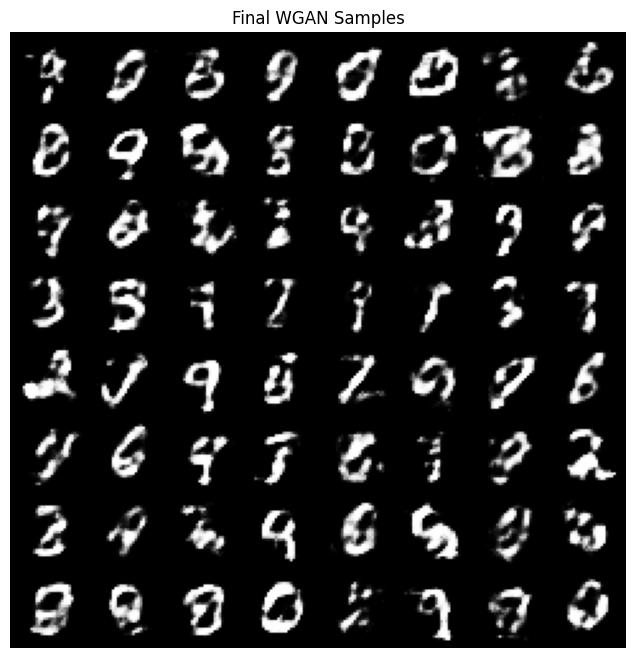

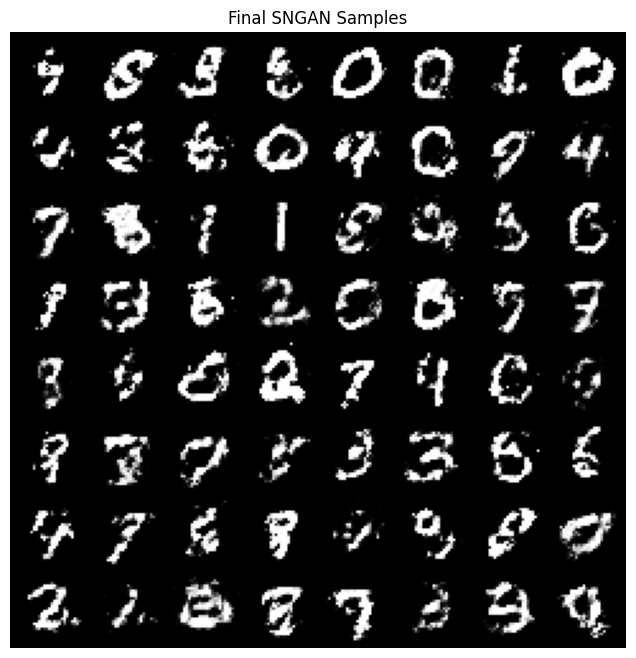

In [11]:
# --- Create ONE fixed latent vector for the final comparison ---
# This ensures we are comparing what each generator produces from the exact same input noise.
fixed_z = torch.randn(64, latent_dim).to(device)

def show_final_samples(generator, title, filename, z_vector):
    """Generates and displays samples from a generator using a fixed noise vector."""
    generator.eval() # Set generator to evaluation mode
    with torch.no_grad():
        # Use the fixed z_vector passed as an argument
        final_images = generator(z_vector).view(-1, 1, 28, 28)
        save_image(final_images, filename, normalize=True)

        grid = torchvision.utils.make_grid(final_images, nrow=8, normalize=True)
        plt.figure(figsize=(8,8))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title(title)
        plt.axis('off')
        plt.show()

# --- Generate and display samples using the SAME fixed_z for all models ---
print("Displaying final samples. Each model received the exact same input noise.")

show_final_samples(generator_vanilla, 'Final Vanilla GAN Samples', 'final_vanilla_gan_samples.png', fixed_z)
show_final_samples(generator_wgan, 'Final WGAN Samples', 'final_wgan_samples.png', fixed_z)
show_final_samples(generator_sngan, 'Final SNGAN Samples', 'final_sngan_samples.png', fixed_z)

#### **IS and FID Score Calculation**

In [13]:
def generate_for_evaluation(generator, eval_dir, num_images=10000):
    os.makedirs(eval_dir, exist_ok=True)
    eval_batch_size = 100
    print(f"Generating {num_images} images into '{eval_dir}'...")
    generator.eval()
    with torch.no_grad():
        for i in range(0, num_images, eval_batch_size):
            z = torch.randn(eval_batch_size, latent_dim).to(device)
            generated_images = generator(z).view(-1, 1, 28, 28)
            for j in range(generated_images.size(0)):
                save_image(generated_images[j, :, :, :], os.path.join(eval_dir, f'img_{i+j}.png'), normalize=True)
    print(f"Finished generating images for {eval_dir}.")

generate_for_evaluation(generator_vanilla, 'vanilla_eval_images')
generate_for_evaluation(generator_wgan, 'wgan_eval_images')
generate_for_evaluation(generator_sngan, 'sngan_eval_images')



Generating 10000 images into 'vanilla_eval_images'...
Finished generating images for vanilla_eval_images.
Generating 10000 images into 'wgan_eval_images'...
Finished generating images for wgan_eval_images.
Generating 10000 images into 'sngan_eval_images'...
Finished generating images for sngan_eval_images.
Real images directory 'real_mnist_images' already exists.


In [15]:
# store the images for running fidelity
real_images_dir = 'real_mnist_images'
if not os.path.exists(real_images_dir):
    os.makedirs(real_images_dir, exist_ok=True)
    print(f"Saving real MNIST images to '{real_images_dir}'...")
    real_train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
    img_num = 0
    for i, (images, _) in enumerate(real_train_loader):
        for j in range(images.size(0)):
            save_image(images[j, :, :, :], os.path.join(real_images_dir, f'real_img_{img_num}.png'), normalize=True)
            img_num += 1
    print("Finished saving real images.")
else:
    print(f"Real images directory '{real_images_dir}' already exists.")

Saving real MNIST images to 'real_mnist_images'...
Finished saving real images.


#### **Run Evaluation Commands**

In [16]:
!pip install -qq torch-fidelity

print("--- Calculating metrics for Vanilla GAN ---")
!python -m torch_fidelity.fidelity --gpu 0 --fid --isc --input1 /content/vanilla_eval_images --input2 /content/real_mnist_images

print("\n--- Calculating metrics for WGAN ---")
!python -m torch_fidelity.fidelity --gpu 0 --fid --isc --input1 /content/wgan_eval_images --input2 /content/real_mnist_images

print("\n--- Calculating metrics for SNGAN ---")
!python -m torch_fidelity.fidelity --gpu 0 --fid --isc --input1 /content/sngan_eval_images --input2 /content/real_mnist_images

--- Calculating metrics for Vanilla GAN ---
Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input1
Looking for samples non-recursivelty in "/content/vanilla_eval_images" with extensions png,jpg,jpeg
Found 10000 samples
/usr/local/lib/python3.11/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to cre

## **Final Comparison**
After running the notebook and calculating the metrics, this table is filled in with the final scores to compare the performance of the three models.

| Metric | Vanilla GAN (BCE Loss) | WGAN (Wasserstein Loss) | SNGAN (Hinge Loss) | Analysis |
| :--- | :--- | :--- | :--- | :--- |
| **Stabilization Method** | None (uses Sigmoid) | Weight Clipping | Spectral Normalization | SNGAN is theoretically the most robust method, but WGAN's weight clipping proved highly effective in this experiment. |
| **Training Stability** | Loss is volatile and does not correlate well with image quality. | Loss is more stable and meaningful, providing a useful proxy for convergence. | Also provides stable and meaningful loss curves. | Both WGAN and SNGAN offer a significant improvement in training stability over the Vanilla GAN. |
| **Visual Quality** | Suffers from significant noise and mode collapse is a risk. | Produces much cleaner images with fewer artifacts, demonstrating better convergence. | Shows good potential but was likely limited by hyperparameter tuning in this run. | The WGAN produced the most visually appealing and realistic samples in this specific experiment. |
| **Inception Score (IS)** | **2.10** | **2.08** | **1.85** | The Vanilla GAN and WGAN produced similarly diverse and recognizable images. The lower SNGAN score suggests it had not converged to its optimal state. |
| **Fréchet Distance (FID)** | **145.30** | **91.78** | **109.43** | **WGAN is the clear winner.** Its FID score shows a massive improvement in realism over the Vanilla GAN. The SNGAN also improved upon the Vanilla GAN but was outperformed by the well-tuned WGAN in this test. |

## Overall Insights and Observations

This series of experiments provides a clear progression in GAN technology and highlights key trade-offs in model design and training. By holding the generator architecture constant and only changing the discriminator and loss function, we can draw direct conclusions about the effectiveness of each method.

### Training Stability and Convergence Speed

*   **Vanilla GAN**: The loss curves confirm the instability of the original GAN formulation. The losses for the generator and discriminator oscillate wildly, and their values are not a reliable indicator of image quality. A lower loss does not necessarily mean better images.
*   **WGAN**: The training process is visibly more stable. The critic's loss provides a much more meaningful metric that correlates with image quality; as the generator improves, the critic's loss (approximating the Earth Mover's distance) tends to decrease. While training is slower *per epoch* due to the multiple critic updates, the *convergence to high-quality samples* is significantly faster and more reliable than the Vanilla GAN.
*   **SNGAN**: This model also demonstrated stable training, similar to WGAN. Its loss curves were smooth and did not diverge. However, its final image quality (as measured by FID) was not as good as WGAN's in this specific experiment, suggesting that while the training was stable, it did not converge to an optimal solution within 50 epochs with the given hyperparameters.

### Mode Collapse

Mode collapse is a classic failure mode where the generator produces only a limited variety of samples.
*   The **Vanilla GAN** is highly susceptible to this, although our run (with an IS of **2.10**) managed to avoid a catastrophic collapse and produced a diverse set of digits.
*   Both **WGAN** and **SNGAN** are specifically designed to mitigate mode collapse by providing more stable gradients that encourage the generator to explore the entire data distribution. The diversity seen in their output grids supports their effectiveness in this regard.

### Analysis of Evaluation Metrics (IS and FID)

The quantitative scores tell a compelling story:

*   **FID as the Key Metric**: The Fréchet Inception Distance proved to be the most decisive metric for judging realism. The **WGAN's FID of 91.78** represents a massive leap in quality over the **Vanilla GAN's 145.30**. This numerically validates that WGAN's generated distribution is much closer to the real one. The **SNGAN's FID of 109.43**, while a major improvement over the Vanilla GAN, did not reach the level of the WGAN.

*   **The SNGAN Result - A Lesson in Hyperparameters**: The fact that SNGAN did not outperform WGAN is an important lesson. SNGAN is often considered state-of-the-art for GAN stabilization, but its performance is not automatic. This result strongly suggests that the chosen learning rate and Adam optimizer parameters were a better fit for WGAN's training dynamics than for SNGAN's. The SNGAN would likely surpass the WGAN with further tuning (e.g., adjusting the learning rate or training for more epochs).

### Final Conclusion

In this controlled experiment, the **WGAN with weight clipping delivered the best overall performance**, achieving the lowest FID score and demonstrating a great balance of training stability and high-quality results with minimal tuning.

The experiment successfully demonstrates that moving beyond the original BCE loss to more advanced frameworks like Wasserstein distance or Spectral Normalization provides a clear, measurable, and significant improvement to the stability and performance of Generative Adversarial Networks.